<a href="https://colab.research.google.com/github/itz-sayak/UCI_HAR_Decision_Tree/blob/main/ML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/itz-sayak/UCI_HAR_Decision_Tree

Cloning into 'UCI_HAR_Decision_Tree'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 109 (delta 49), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 49.92 KiB | 4.16 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
import os
import zipfile
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
dest_path = "/content/UCI_HAR_Dataset.zip"

# Download the dataset
urllib.request.urlretrieve(url, dest_path)

# Extract the dataset
with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall("/content/UCI_HAR_Dataset")

extracted_path = "/content/UCI_HAR_Dataset"
if os.path.exists(extracted_path):
    print("Dataset downloaded and extracted successfully.")
else:
    print("Failed to extract dataset.")


Dataset downloaded and extracted successfully.


## Task 1 : Exploratory Data Analysis (EDA)
### Preprocessing

In [3]:
import shutil

# Define paths
src_folder = '/content/UCI_HAR_Decision_Tree/HAR/'
dest_folder = '/content/UCI_HAR_Dataset/UCI_HAR_Dataset/'

# Move CombineScript.py and MakeDataset.py to the UCI dataset folder
shutil.move(src_folder + 'CombineScript.py', dest_folder + 'CombineScript.py')
shutil.move(src_folder + 'MakeDataset.py', dest_folder + 'MakeDataset.py')


'/content/UCI_HAR_Dataset/UCI_HAR_Dataset/MakeDataset.py'

In [4]:
!python /content/UCI_HAR_Dataset/UCI_HAR_Dataset/CombineScript.py

Done Combining the training data
Done Combining the testing data
Done Combining the data


In [5]:
!python /content/UCI_HAR_Dataset/UCI_HAR_Dataset/MakeDataset.py

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


### Questions
1.1 Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? [0.5 marks]

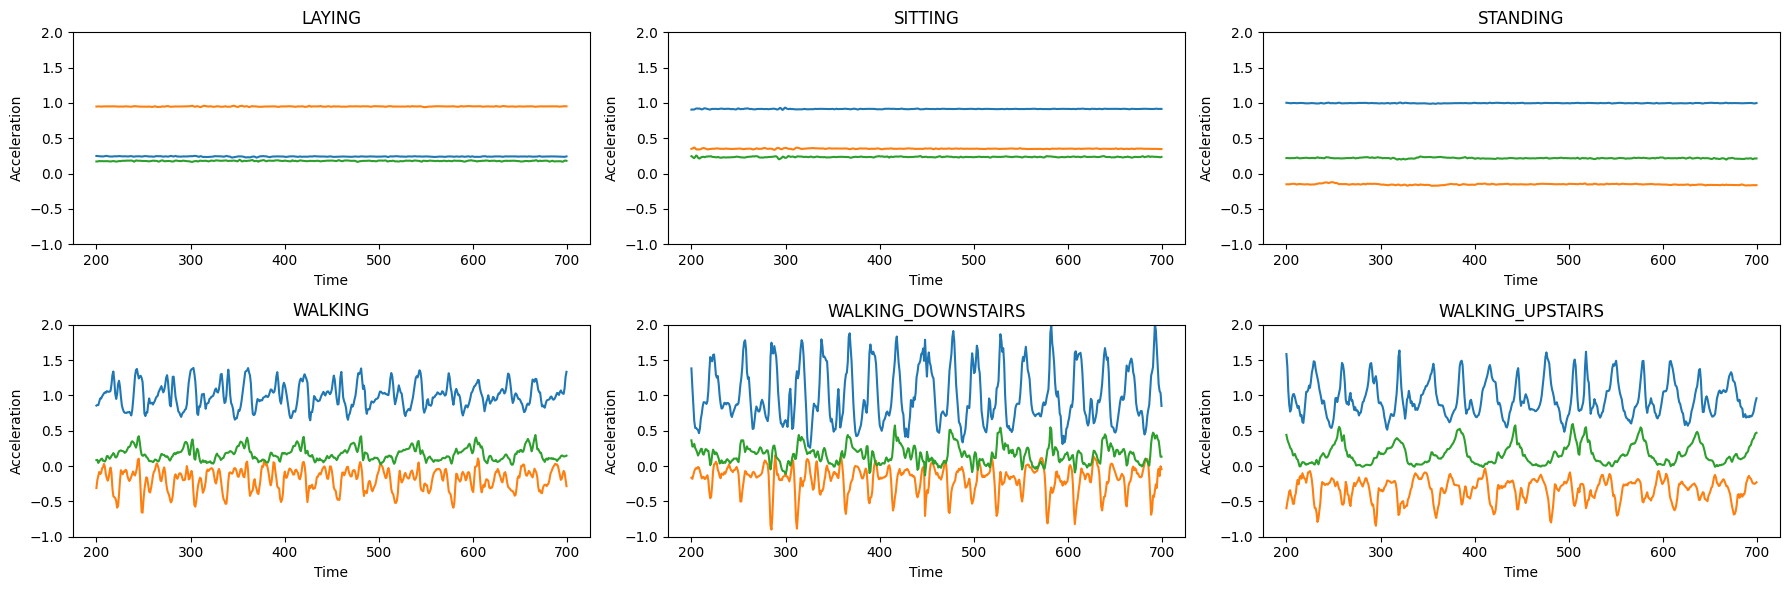

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the path to the Combined dataset
combined_folder = '/content/Combined/'

# Define the activities
activities = ['LAYING',
              'SITTING',
              'STANDING',
              'WALKING',
              'WALKING_DOWNSTAIRS',
              'WALKING_UPSTAIRS']

# Initialize a list to store data for each activity
data_samples = []

# Load one sample from each activity
for activity in activities:
    activity_folder = os.path.join(combined_folder, 'Train', activity)
    sample_file = os.listdir(activity_folder)[0]
    sample_path = os.path.join(activity_folder, sample_file)
    data = pd.read_csv(sample_path)
    data = data[200:700]
    data_samples.append((activity, data))

# Plot the waveforms
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
axes =axes.flatten()
for i, (activity, data) in enumerate(data_samples):
    axes[i].plot(data.iloc[:, 0:3])  # Plotting the first three columns (e.g., x, y, z accelerations)
    axes[i].set_title(activity)
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Acceleration')

    axes[i].set_ylim(-1, 2)

plt.tight_layout()
plt.show()


> The model will mostly be able to identify whether the activity is static or dynamic, but it might have difficulty identifying which specific activity is being performed within the static and dynamic categories.

In [8]:
data_samples

[('LAYING',
           accx      accy      accz
  200  0.249718  0.949512  0.171769
  201  0.249335  0.949380  0.171254
  202  0.246799  0.952028  0.173794
  203  0.245580  0.950865  0.178079
  204  0.245049  0.950124  0.176785
  ..        ...       ...       ...
  695  0.238858  0.951409  0.167258
  696  0.238108  0.954144  0.174339
  697  0.237497  0.953263  0.183180
  698  0.240360  0.953356  0.184490
  699  0.243723  0.952409  0.180534
  
  [500 rows x 3 columns]),
 ('SITTING',
           accx      accy      accz
  200  0.905729  0.350861  0.246058
  201  0.908264  0.353976  0.239225
  202  0.906348  0.362124  0.224705
  203  0.908077  0.369906  0.219560
  204  0.914210  0.361231  0.234660
  ..        ...       ...       ...
  695  0.915756  0.349439  0.234941
  696  0.914613  0.348528  0.233845
  697  0.916309  0.347033  0.231684
  698  0.915029  0.347419  0.231758
  699  0.916068  0.347526  0.235918
  
  [500 rows x 3 columns]),
 ('STANDING',
           accx      accy      accz
 

In [7]:
!pip install -q tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.0 MB/s eta 0:00:00


# Sampling down to 500 dimension

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the directory path
base_dir = "/content/Combined/Train"

# Initialize lists to hold data and labels
data = []
labels = []
acc_data = []

# Iterate through each activity class folder
for activity in os.listdir(base_dir):
    activity_dir = os.path.join(base_dir, activity)

    # Iterate through each subject file in the activity folder
    for file_name in os.listdir(activity_dir):
        file_path = os.path.join(activity_dir, file_name)

        # Load the CSV file
        df = pd.read_csv(file_path)

        # Compute total acceleration
        df['total_acc'] = np.sqrt(df['accx']**2 + df['accy']**2 + df['accz']**2)
        df['total'] = df['accx']**2 + df['accy']**2 + df['accz']**2
        df = df[200:700]

        # Append the total acceleration and label to the lists
        data.append(df['total_acc'].values)
        acc_data.append(df['total'].values)
        labels.append(activity)

# Convert data and labels to a numpy array
data = np.array(data)
labels = np.array(labels)

print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (126, 500)
Labels shape: (126,)


1.2 Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration
(accx2+accy2+accz2)
 for each activity and justify your answer. [0.5 marks]

In [10]:
df_1 = pd.DataFrame(acc_data)
df_1['label'] = labels

group_data = df_1.groupby('label').mean()
group_data_array = group_data.values

print(f"Grouped data shape: {group_data_array.shape}")

for activity, row in group_data.iterrows():
    print(f"Activity: {activity} | Data: {row.values[:30]}")

Grouped data shape: (6, 500)
Activity: LAYING | Data: [1.00904    1.00947301 1.00924222 1.00825765 1.00697351 1.00721041
 1.00909951 1.00933441 1.00834424 1.00735302 1.00770575 1.00855084
 1.00814538 1.00797104 1.00733106 1.00745327 1.00971171 1.01056777
 1.0097078  1.00948097 1.00891101 1.00633234 1.006028   1.01030634
 1.01218521 1.01001688 1.00870178 1.00824874 1.00686489 1.00648748]
Activity: SITTING | Data: [1.02912191 1.03115009 1.03115166 1.02964174 1.02905901 1.02882798
 1.02870875 1.02868577 1.02946509 1.02975621 1.02725432 1.02481041
 1.02446612 1.02561103 1.02870023 1.03170348 1.03288372 1.03359393
 1.03505129 1.036015   1.0351734  1.03444444 1.03247525 1.02953383
 1.03095056 1.03493679 1.03707942 1.03553872 1.03352386 1.03587785]
Activity: STANDING | Data: [1.06956726 1.0630864  1.06499441 1.0660763  1.06430178 1.06671638
 1.0675774  1.0668659  1.06575633 1.06291771 1.0618406  1.06266706
 1.0631774  1.06342802 1.06437416 1.06387164 1.06226065 1.06300358
 1.06532609 1.067109

> No, a machine learning model might not be necessary.The acceleration values for static activities are more uniform and lower, whereas dynamic activities have more varied and higher values.It might be possible to differentiate between them using simple threshold-based approach.

# 500 dim -> PCA(n=2)

1.3.1 Use PCA (Principal Component Analysis) on Total Acceleration
(accx2+accy2+accz2) to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

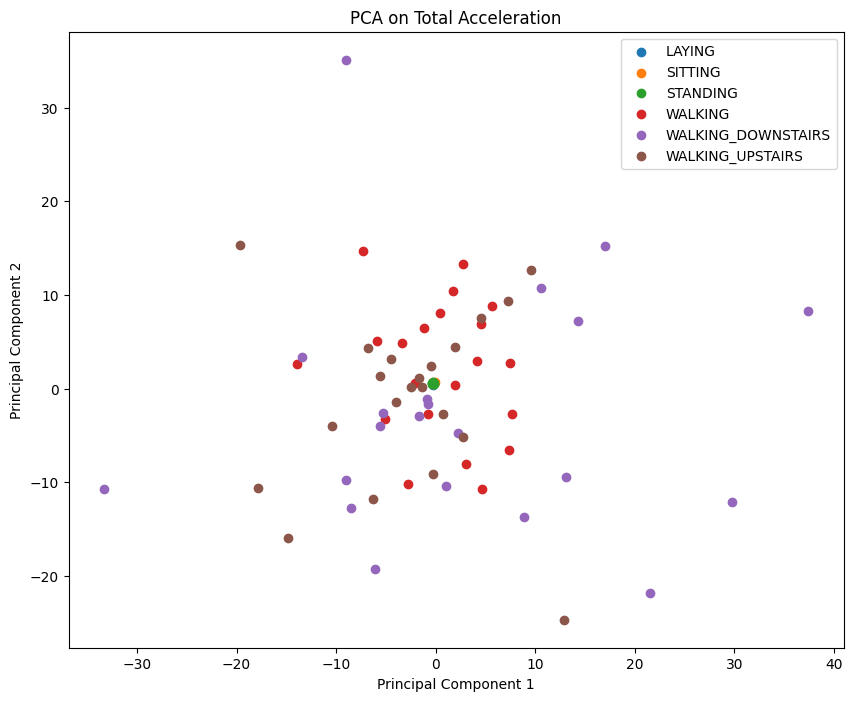

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 8))
for activity in np.unique(labels):
    plt.scatter(pca_result[labels == activity, 0], pca_result[labels == activity, 1], label=activity)

plt.title("PCA on Total Acceleration")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# TSFEL (500 dim)

In [ ]:
# nan_counts = features_df.isna().sum()
# columns_with_nan = nan_counts[nan_counts > 0]
# print(columns_with_nan)

1.3.2 Use TSFEL (a featurizer library) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


/usr/local/lib/python3.10/dist-packages/tsfel/feature_extraction/features.py:498: FutureWarning: The histogram feature was deprecated in version 0.1.8 and will be replaced by the mode of histogram in 0.1.9. From then on, only a single feature value will be returned.
  warnings.warn(
<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


<ipython-input-12-4ce6dfa24e5c>:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(cfg, seq)


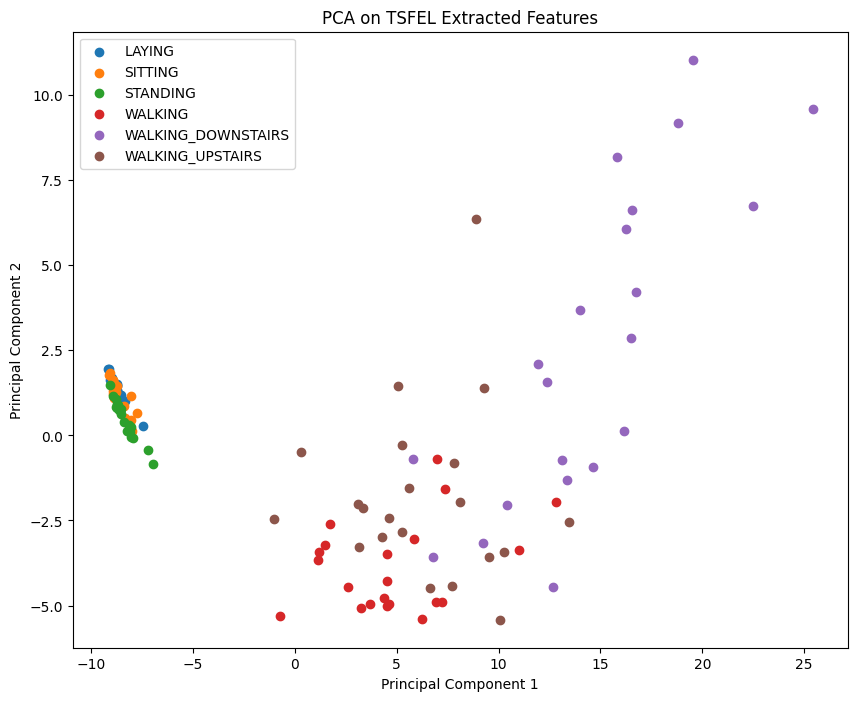

In [12]:
import tsfel
# Define the TSFEL feature extraction settings
cfg = tsfel.get_features_by_domain()

# Initialize a list to hold all extracted features
extracted_features = []

# Extract features from each sequence
for seq in data:
    features = tsfel.time_series_features_extractor(cfg, seq)
    extracted_features.append(features)

# Concatenate all individual DataFrames into a single DataFrame
features_df = pd.concat(extracted_features, ignore_index=True)

# Handle NaN values (choose one strategy)
# Option 1: Fill NaN values with 0
features_df_filled = features_df.fillna(0)

# Option 2: Drop rows with NaN values
# features_df_dropped = features_df.dropna()

# Standardize the features before applying PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df_filled)

# Apply PCA
pca_features = PCA(n_components=2)
pca_result_features = pca_features.fit_transform(features_scaled)

# Plot the PCA results
plt.figure(figsize=(10, 8))
for activity in np.unique(labels):
    plt.scatter(pca_result_features[labels == activity, 0], pca_result_features[labels == activity, 1], label=activity)

plt.title("PCA on TSFEL Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [13]:
print(features_df.shape)

(126, 165)


In [14]:
print(pca_result_features)

[[-8.92009785  1.58627296]
 [-9.05316252  1.83385594]
 [-8.92278392  1.64087728]
 [-8.37875466  0.87571697]
 [-9.10232127  1.77371573]
 [-8.92442697  1.2117719 ]
 [-8.90345394  1.30294682]
 [-8.76510865  1.27445941]
 [-8.83665459  1.49159263]
 [-8.73260592  1.45527834]
 [-8.85586509  1.08910128]
 [-8.81383966  1.21662069]
 [-7.97396726  0.11668611]
 [-8.02932754  0.45088925]
 [-8.92266955  1.5782135 ]
 [-8.94593473  1.42105649]
 [-8.9273651   1.59800087]
 [-7.73938198  0.65031001]
 [-8.06545708  1.14426963]
 [-8.59894259  0.84583972]
 [-8.34885261  0.5131651 ]
 [ 1.14567336 -3.65343966]
 [ 4.51834145 -4.27810421]
 [ 4.53798084 -3.49794334]
 [ 2.58790393 -4.445165  ]
 [ 3.71263755 -4.95391967]
 [ 6.23057535 -5.39232139]
 [ 3.24002351 -5.05987514]
 [ 1.7459525  -2.60612588]
 [12.79896336 -1.95847295]
 [ 1.2040234  -3.42284649]
 [ 7.23252578 -4.89623077]
 [ 4.54654292 -5.01619687]
 [ 4.3974542  -4.78365433]
 [ 7.3610927  -1.56797399]
 [10.99014009 -3.36021037]
 [ 6.99270071 -0.70772971]
 

1.3.3 Use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

In [15]:
# Load the pre-extracted features from the dataset
feature_data = pd.read_csv('/content/UCI_HAR_Dataset/UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Load the activity labels
feature_label = pd.read_csv('/content/UCI_HAR_Dataset/UCI_HAR_Dataset/train/y_train.txt', header=None)

# Load the activity names
activity_labels = pd.read_csv('/content/UCI_HAR_Dataset/UCI_HAR_Dataset/activity_labels.txt', delim_whitespace=True, header=None)
activity_labels.columns = ['label', 'activity']

# Map the activity labels to their corresponding names
feature_label = feature_label[0].map(activity_labels.set_index('label')['activity'])

print(f"Feature data shape: {feature_data.shape}")
print(f"Labels shape: {feature_label.shape}")


Feature data shape: (7352, 561)
Labels shape: (7352,)


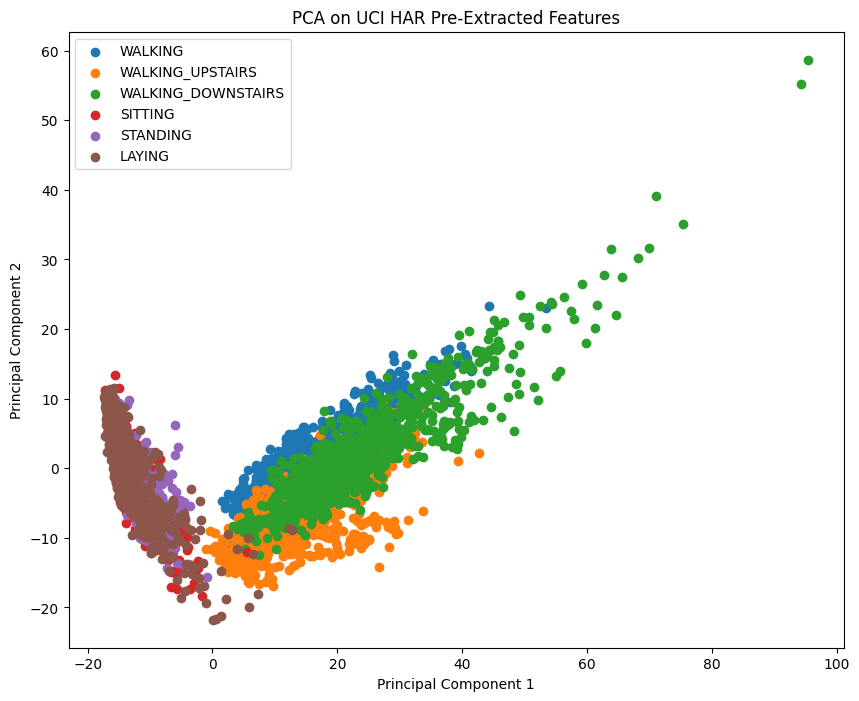

In [16]:
# Standardize the features before applying PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_data)

# Apply PCA to reduce to two dimensions
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Plot the PCA results
plt.figure(figsize=(10, 8))
for activity in activity_labels['activity']:
    plt.scatter(pca_result[feature_label == activity, 0], pca_result[feature_label == activity, 1], label=activity)

plt.title("PCA on UCI HAR Pre-Extracted Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

1.3.4 Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

> We get best result and visible clusters with PCA on dataset features compare to PCA on total acceleration and PCA on TSFEL.

## Correlation Matrix

1.4 Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? [1 marks]

In [17]:
#features_df has features obtained by TSFEL
print(features_df.shape)
#feature_data has features given in dataset
print(feature_data.shape)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_data)

TSFEL_scaled_features = scaler.fit_transform(features_df)

feature_data_reduced = scaled_features[100:226]

print(feature_data_reduced.shape)

TSFEL_scaled_features_df = pd.DataFrame(TSFEL_scaled_features)
feature_data_reduced_df = pd.DataFrame(feature_data_reduced)

#To combine column-wise axis=1
combined_features = pd.concat([TSFEL_scaled_features_df,feature_data_reduced_df],axis=1)

print(combined_features.shape)

correlation_matrix = combined_features.corr()
print(correlation_matrix.shape)

(126, 165)
(7352, 561)
(126, 561)
(126, 726)
(726, 726)


In [18]:
correlation_matrix

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,1.000000,0.805892,-0.064684,1.000000,0.117925,NaN,NaN,-0.930360,0.970706,NaN,...,-0.142814,-0.098554,-0.169969,-0.061301,0.051651,0.026441,-0.006875,0.243567,-0.205037,-0.206568
1,0.805892,1.000000,-0.102247,0.805892,0.100291,NaN,NaN,-0.608096,0.708447,NaN,...,-0.157821,-0.082956,-0.174726,-0.056142,0.059458,-0.003750,-0.064617,0.246774,-0.267527,-0.227454
2,-0.064684,-0.102247,1.000000,-0.064684,-0.066555,NaN,NaN,0.015263,-0.034538,NaN,...,0.023905,0.047515,0.023869,-0.042130,0.030845,-0.078519,-0.029455,-0.019463,-0.013642,-0.005939
3,1.000000,0.805892,-0.064684,1.000000,0.117925,NaN,NaN,-0.930360,0.970706,NaN,...,-0.142814,-0.098554,-0.169969,-0.061301,0.051651,0.026441,-0.006875,0.243567,-0.205037,-0.206568
4,0.117925,0.100291,-0.066555,0.117925,1.000000,NaN,NaN,-0.088389,0.141602,NaN,...,0.029668,0.055592,0.041003,-0.063447,-0.127764,-0.094212,0.070080,-0.092022,0.121369,0.088870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0.026441,-0.003750,-0.078519,0.026441,-0.094212,NaN,NaN,-0.056923,0.041992,NaN,...,0.040143,0.080984,0.086057,0.004585,0.162216,1.000000,-0.094606,-0.060168,0.020149,0.006524
557,-0.006875,-0.064617,-0.029455,-0.006875,0.070080,NaN,NaN,-0.033629,0.011374,NaN,...,-0.004666,-0.002534,-0.027765,-0.107447,0.040339,-0.094606,1.000000,0.053641,-0.050722,-0.047947
558,0.243567,0.246774,-0.019463,0.243567,-0.092022,NaN,NaN,-0.305773,0.249251,NaN,...,0.296133,-0.300604,-0.219562,-0.016008,0.051290,-0.060168,0.053641,1.000000,-0.933053,-0.889067
559,-0.205037,-0.267527,-0.013642,-0.205037,0.121369,NaN,NaN,0.288307,-0.216056,NaN,...,-0.260918,0.195485,0.128314,-0.008429,-0.064152,0.020149,-0.050722,-0.933053,1.000000,0.977067


In [19]:
correlation_matrix.fillna(0, inplace=True)
print(correlation_matrix.isna().sum().sum())

threshold = 0.8  # Adjust the threshold as needed
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if i != j:
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                feature_1 = correlation_matrix.columns[i]
                feature_2 = correlation_matrix.columns[j]
                highly_correlated_pairs.append((feature_1, feature_2, corr_value))

print(len(highly_correlated_pairs))

# for pair in highly_correlated_pairs:
#     print(f"{pair[0]} and {pair[1]} with correlation: {pair[2]}")

0
34979


# Modelling

In [20]:
activity_map = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

reverse_map ={
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 2,
    'WALKING_DOWNSTAIRS' : 3,
    'SITTING' : 4,
    'STANDING' : 5,
    'LAYING' : 6
}

2.1 Use Sklearn Library to train Decision Tress. [1.5 marks]

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pickle

# Function to load and preprocess data
def load_and_preprocess_data(base_dir):
    print("\nload_and_preprocess_data")
    data = []
    labels = []

    for activity in os.listdir(base_dir):
        activity_dir = os.path.join(base_dir, activity)

        for file_name in os.listdir(activity_dir):
            file_path = os.path.join(activity_dir, file_name)

            df = pd.read_csv(file_path)
            df = df[200:700]
            df.loc[:, 'total_acc'] = np.sqrt(df['accx']**2 + df['accy']**2 + df['accz']**2)

            data.append(df['total_acc'].values)
            labels.append(activity)

    data = np.array(data)
    labels = np.array(labels)

    print(data)
    print(data.shape)
    print("-"*50)

    return data, labels

def load_and_preprocess_raw_data(base_dir):
    print("\nload_and_preprocess_raw_data")
    data = []
    labels = []

    for activity in os.listdir(base_dir):
        activity_dir = os.path.join(base_dir, activity)

        for file_name in os.listdir(activity_dir):
            file_path = os.path.join(activity_dir, file_name)

            df = pd.read_csv(file_path)
            df = df[200:700]

            data.append(df)
            activity_label = np.full((500,),reverse_map[activity])
            labels.append(activity_label)

    data = pd.concat(data,ignore_index=True)
    labels = np.concatenate(labels).reshape(-1, 1)

    print(data)
    print(data.shape)
    print("-"*50)

    return data, labels

def train_and_evaluate(X_train, y_train, X_test, y_test):
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    clf = DecisionTreeClassifier(random_state=42)

    # Train Decision Tree model
    # clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return clf, accuracy, precision, recall, cm

In [23]:
train_dir = "/content/Combined/Train"
test_dir = "/content/Combined/Test"

data_train, labels_train = load_and_preprocess_data(train_dir)
data_test, labels_test = load_and_preprocess_data(test_dir)

raw_data_train, raw_labels_train = load_and_preprocess_raw_data(train_dir)
raw_data_test, raw_labels_test = load_and_preprocess_raw_data(test_dir)

print(f"Raw Data Training shape: {raw_data_train.shape}")
print(f"Raw Data Training label shape: {raw_labels_train.shape}")
print(f"Raw Data Testing shape: {raw_data_test.shape}")
print(f"Raw Data Testing label shape: {raw_labels_test.shape}")


load_and_preprocess_data
[[1.00199447 1.00372879 1.00154526 ... 1.00684235 1.00582784 1.0077762 ]
 [1.00783328 1.00345923 1.00343209 ... 1.01056153 1.00973935 1.00933982]
 [1.004046   1.00191904 1.00023796 ... 1.00481798 1.00550077 1.00504181]
 ...
 [1.46265007 1.46486477 1.41083848 ... 1.04661503 0.96387786 0.81348884]
 [1.02640046 1.03427783 1.02159075 ... 0.85243018 0.7852113  0.78675265]
 [1.12599285 1.28071927 1.45553678 ... 1.12808736 1.13783282 1.22522372]]
(126, 500)
--------------------------------------------------

load_and_preprocess_data
[[1.02340927 1.01991203 1.01601626 ... 1.01980409 1.01748468 1.01872066]
 [1.00541075 1.00898155 1.00996921 ... 1.00616208 1.00859741 1.01046628]
 [1.01541896 1.02068797 1.02777189 ... 1.02223177 1.02177827 1.02241459]
 ...
 [0.50234218 0.69949893 0.93680334 ... 1.3612106  1.0142543  0.76385419]
 [0.89680606 0.91225155 0.92757674 ... 1.22745201 1.13541105 1.0494096 ]
 [1.08610315 1.05556066 1.08476954 ... 0.92824061 0.93664313 0.95556335]

i) Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

In [24]:
# Model 1: Raw Accelerometer Data
clf_raw_acceleration,accuracy_raw, precision_raw, recall_raw, cm_raw = train_and_evaluate(raw_data_train, raw_labels_train, raw_data_test, raw_labels_test)
print(f"Raw Data - Accuracy: {accuracy_raw}, Precision: {precision_raw}, Recall: {recall_raw}")
print(f"Confusion Matrix:\n{cm_raw}\n")

model_path = "/content/raw_accelerometer_decision_tree_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(clf_raw_acceleration, model_file)

Raw Data - Accuracy: 0.5777407407407408, Precision: 0.6341936104237741, Recall: 0.5777407407407408
Confusion Matrix:
[[1750 1278 1324   23  125    0]
 [1403 1884 1141    9   63    0]
 [1387 1146 1890   18   59    0]
 [ 505  405  124 3191  275    0]
 [1042  705  251  118 2384    0]
 [   0    0    0    0    0 4500]]



ii) Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

In [25]:
cfg1 = tsfel.get_features_by_domain()

# Extract TSFEL features for training and testing separately
tsfel_features_train = pd.DataFrame()
for i in range(data_train.shape[0]):
    tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))
    tsfel_features_train = pd.concat([tsfel_features_train, tsfel_features])

tsfel_features_test = pd.DataFrame()
for i in range(data_test.shape[0]):
    tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))
    tsfel_features_test = pd.concat([tsfel_features_test, tsfel_features])

# Ensure the feature columns match
common_columns = tsfel_features_train.columns.intersection(tsfel_features_test.columns)
tsfel_features_train = tsfel_features_train[common_columns]
tsfel_features_test = tsfel_features_test[common_columns]

# Verify shapes
print(f"TSFEL Features Training shape: {tsfel_features_train.shape}")
print(f"TSFEL Features Testing shape: {tsfel_features_test.shape}")

# Model 2: TSFEL Features
clf_tsfel,accuracy_tsfel, precision_tsfel, recall_tsfel, cm_tsfel = train_and_evaluate(tsfel_features_train, labels_train, tsfel_features_test, labels_test)
print(f"TSFEL Features - Accuracy: {accuracy_tsfel}, Precision: {precision_tsfel}, Recall: {recall_tsfel}")
print(f"Confusion Matrix:\n{cm_tsfel}\n")

# Save Model 2 (TSFEL Features) using pickle
model_path = "/content/tsfel_decision_tree_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(clf_tsfel, model_file)

<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:6: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_train[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


<ipython-input-25-6e252c026b9a>:11: UserWarning: Using default sampling frequency set in configuration file.
  tsfel_features = tsfel.time_series_features_extractor(cfg1, data_test[i].reshape(-1, 1))


TSFEL Features Training shape: (126, 165)
TSFEL Features Testing shape: (54, 165)
TSFEL Features - Accuracy: 0.7962962962962963, Precision: 0.7987193362193362, Recall: 0.7962962962962963
Confusion Matrix:
[[5 4 0 0 0 0]
 [1 7 1 0 0 0]
 [1 0 8 0 0 0]
 [0 0 0 7 0 2]
 [0 0 0 0 9 0]
 [0 0 0 1 1 7]]



iii) Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.



In [26]:
# Paths to the dataset
train_path = '/content/UCI_HAR_Dataset/UCI_HAR_Dataset/train/'
test_path = '/content/UCI_HAR_Dataset/UCI_HAR_Dataset/test/'

# Load the provided features and labels for training
X_train = pd.read_csv(train_path + 'X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv(train_path + 'y_train.txt', delim_whitespace=True, header=None).values.ravel()

# Load the provided features and labels for testing
X_test = pd.read_csv(test_path + 'X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv(test_path + 'y_test.txt', delim_whitespace=True, header=None).values.ravel()

# Model 3: Provided Features
clf_feature_dataset,accuracy_provided, precision_provided, recall_provided, cm_provided = train_and_evaluate(X_train, y_train, X_test, y_test)
print(f"Provided Features - Accuracy: {accuracy_provided}, Precision: {precision_provided}, Recall: {recall_provided}")
print(f"Confusion Matrix:\n{cm_provided}\n")

model_path = "/content/feature_dataset_decision_tree_model.pkl"
with open(model_path, 'wb') as model_file:
    pickle.dump(clf_feature_dataset, model_file)

Provided Features - Accuracy: 0.8622327790973872, Precision: 0.8632726592620287, Recall: 0.8622327790973872
Confusion Matrix:
[[456  24  16   0   0   0]
 [ 74 369  28   0   0   0]
 [ 19  53 348   0   0   0]
 [  0   0   0 374 117   0]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]



In [27]:
print("X_Train: ",X_train.shape)
print("y_Train: ",y_train.shape)
print("X_Test: ",X_test.shape)
print("y_Test: ",y_test.shape)

X_Train:  (7352, 561)
y_Train:  (7352,)
X_Test:  (2947, 561)
y_Test:  (2947,)


iv) Compare the results of the three models. Which model do you think is better?

In [28]:
print("Comparison of the models:")
print(f"Raw Data - Accuracy: {accuracy_raw}, Precision: {precision_raw}, Recall: {recall_raw}")
print(f"TSFEL Features - Accuracy: {accuracy_tsfel}, Precision: {precision_tsfel}, Recall: {recall_tsfel}")
print(f"Provided Features - Accuracy: {accuracy_provided}, Precision: {precision_provided}, Recall: {recall_provided}")

Comparison of the models:
Raw Data - Accuracy: 0.5777407407407408, Precision: 0.6341936104237741, Recall: 0.5777407407407408
TSFEL Features - Accuracy: 0.7962962962962963, Precision: 0.7987193362193362, Recall: 0.7962962962962963
Provided Features - Accuracy: 0.8622327790973872, Precision: 0.8632726592620287, Recall: 0.8622327790973872


> Model with provided feature is better as not only accuracy but precision and recall are also high.

# 500 dim depth 2-8 DT

2.2 Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]

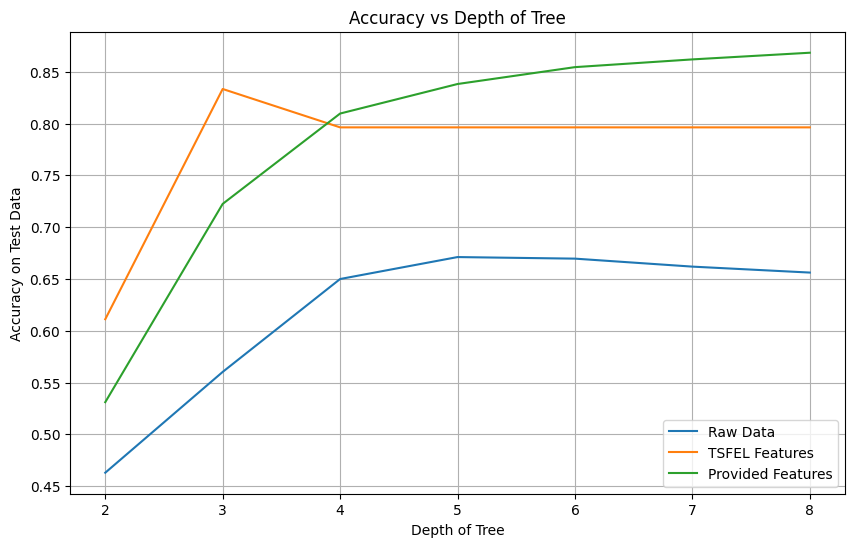

In [29]:
import matplotlib.pyplot as plt

def train_and_evaluate_with_depth(X_train, y_train, X_test, y_test, max_depth):
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Initialize lists to store accuracies
depths = range(2, 9)
accuracies_raw = []
accuracies_tsfel = []
accuracies_provided = []

# Standardize the raw data
scaler_provided = StandardScaler()
X_train_raw_scaled = scaler_provided.fit_transform(raw_data_train)
X_test_raw_scaled = scaler_provided.transform(raw_data_test)

# Standardize the TSFEL features
scaler_tsfel = StandardScaler()
X_train_tsfel_scaled = scaler_tsfel.fit_transform(tsfel_features_train)
X_test_tsfel_scaled = scaler_tsfel.transform(tsfel_features_test)

# Standardize the provided features
scaler_provided = StandardScaler()
X_train_provided_scaled = scaler_provided.fit_transform(X_train)
X_test_provided_scaled = scaler_provided.transform(X_test)

# Loop over depths and train/evaluate models
for depth in depths:
    # Raw Data
    accuracy_raw = train_and_evaluate_with_depth(X_train_raw_scaled, raw_labels_train, X_test_raw_scaled, raw_labels_test, depth)
    accuracies_raw.append(accuracy_raw)

    # TSFEL Features
    accuracy_tsfel = train_and_evaluate_with_depth(X_train_tsfel_scaled, labels_train, X_test_tsfel_scaled, labels_test, depth)
    accuracies_tsfel.append(accuracy_tsfel)

    # Provided Features
    accuracy_provided = train_and_evaluate_with_depth(X_train_provided_scaled, y_train, X_test_provided_scaled, y_test, depth)
    accuracies_provided.append(accuracy_provided)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies_raw, label='Raw Data')
plt.plot(depths, accuracies_tsfel, label='TSFEL Features')
plt.plot(depths, accuracies_provided, label='Provided Features')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy on Test Data')
plt.title('Accuracy vs Depth of Tree')
plt.legend()
plt.grid(True)
plt.show()

2.3 Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

0.5777407407407408


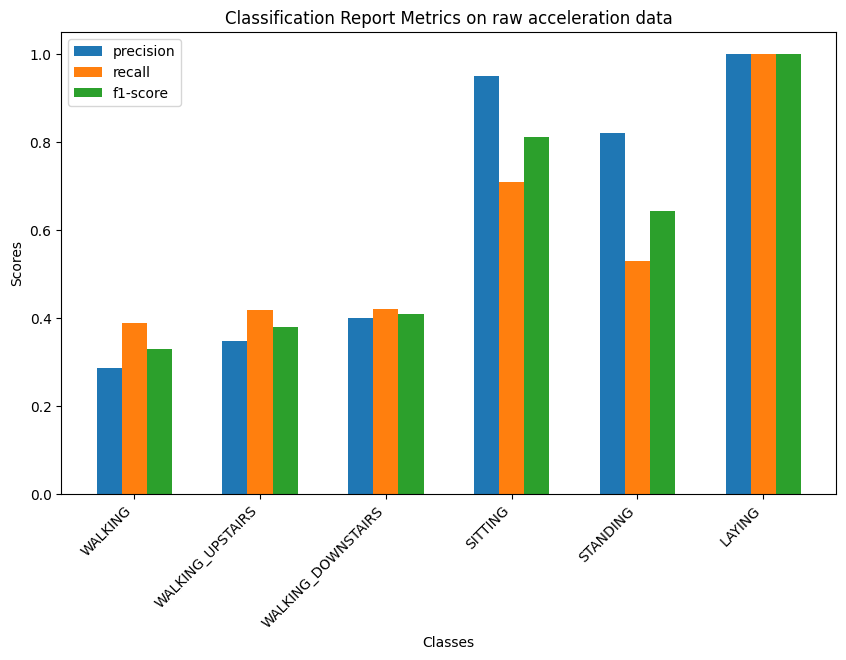

In [30]:
from sklearn.metrics import classification_report

y_true = raw_labels_test

scaler_raw = StandardScaler()
scaler_raw.fit_transform(np.array(raw_data_train))
input_test = scaler_raw.transform(np.array(raw_data_test))

y_pred_raw = clf_raw_acceleration.predict(input_test)

accuracy_temp = accuracy_score(y_true, y_pred_raw)
print(accuracy_temp)

report_raw = classification_report(y_true, y_pred_raw, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
classes = list(report_raw.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
scores_raw = {metric: [report_raw[cls][metric] for cls in classes] for metric in metrics}

x = np.arange(len(classes))  # The label locations
width = 0.2  # The width of the bars

fig_raw, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, scores_raw[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics on raw acceleration data')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
plt.xticks(rotation=45, ha='right')
ax.legend()

plt.show()

In [31]:
print(classification_report(y_true, y_pred_raw, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=False))

                    precision    recall  f1-score   support

           WALKING       0.29      0.39      0.33      4500
  WALKING_UPSTAIRS       0.35      0.42      0.38      4500
WALKING_DOWNSTAIRS       0.40      0.42      0.41      4500
           SITTING       0.95      0.71      0.81      4500
          STANDING       0.82      0.53      0.64      4500
            LAYING       1.00      1.00      1.00      4500

          accuracy                           0.58     27000
         macro avg       0.63      0.58      0.60     27000
      weighted avg       0.63      0.58      0.60     27000



The model is struggling with activities like "WALKING," "WALKING_UPSTAIRS," "WALKING_DOWNSTAIRS," and "STANDING."

- **WALKING:** The model is not great at identifying "WALKING," with low precision (0.29) and recall (0.39). It's likely confusing it with similar activities like walking upstairs or downstairs.

- **WALKING_UPSTAIRS:** Similar story here—precision (0.35) and recall (0.42) are low, indicating that the model can't differentiate this activity well.

- **WALKING_DOWNSTAIRS:** Slightly better than the others, but still not good, with moderate precision (0.40) and recall (0.42).

- **STANDING:** While the precision is decent (0.82), the recall (0.53) isn't, meaning the model often misses "STANDING" when it's actually happening.

**Why is this happening?**

The model might be confusing these activities because they have overlapping features. It might also be that the model isn't complex enough to pick up on subtle differences, or the training data doesn't provide enough distinct information to tell them apart.

In short, the model is struggling with these similar activities and isn't accurately identifying them.

0.7962962962962963


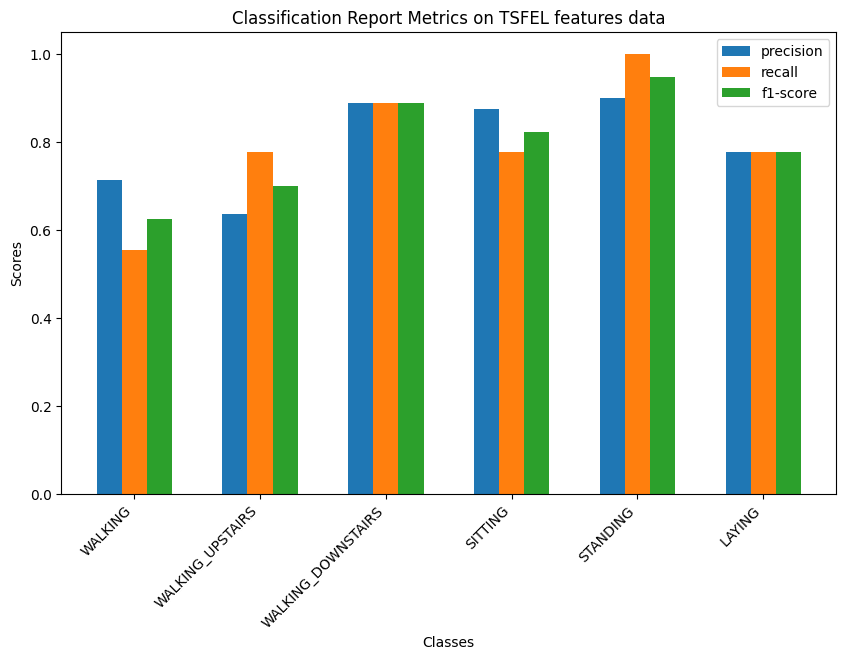

In [32]:
scaler_tsfel = StandardScaler()
scaler_tsfel.fit_transform(np.array(tsfel_features_train))
input_test_tsfel = scaler_tsfel.transform(np.array(tsfel_features_test))

y_pred_tsfel = clf_tsfel.predict(input_test_tsfel)

accuracy_temp = accuracy_score(labels_test, y_pred_tsfel)
print(accuracy_temp)

report_tsfel = classification_report(labels_test, y_pred_tsfel, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
classes = list(report_tsfel.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
scores_tsfel = {metric: [report_tsfel[cls][metric] for cls in classes] for metric in metrics}

x = np.arange(len(classes))  # The label locations
width = 0.2  # The width of the bars

fig_raw, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, scores_tsfel[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics on TSFEL features data')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
plt.xticks(rotation=45, ha='right')
ax.legend()

plt.show()

In [33]:
print(classification_report(labels_test, y_pred_tsfel, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=False))

                    precision    recall  f1-score   support

           WALKING       0.71      0.56      0.63         9
  WALKING_UPSTAIRS       0.64      0.78      0.70         9
WALKING_DOWNSTAIRS       0.89      0.89      0.89         9
           SITTING       0.88      0.78      0.82         9
          STANDING       0.90      1.00      0.95         9
            LAYING       0.78      0.78      0.78         9

          accuracy                           0.80        54
         macro avg       0.80      0.80      0.79        54
      weighted avg       0.80      0.80      0.79        54



> The Decision Tree model with the TSFEL dataset shows generally good performance across all activities, with high precision, recall, and F1-scores.
- WALKING is the class where the model struggles the most. Although it has decent precision (71%), meaning when it predicts 'WALKING,' it's correct most of the time, it has lower recall (56%).
- This suggests that the model is missing a lot of actual 'WALKING' instances. This could be because the features used aren't distinguishing 'WALKING' well enough from other activities, or maybe 'WALKING' shares some similarities with other movements.

0.8622327790973872


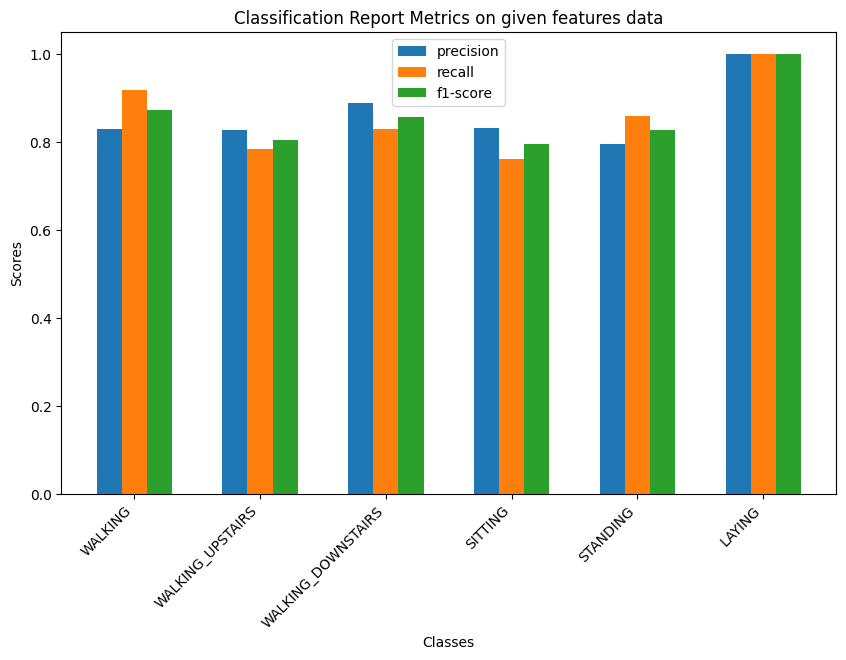

In [35]:
scaler_feature = StandardScaler()
scaler_feature.fit_transform(np.array(X_train))
input_test_feature = scaler_feature.transform(np.array(X_test))

y_pred_feature = clf_feature_dataset.predict(input_test_feature)

accuracy_temp = accuracy_score(y_test, y_pred_feature)
print(accuracy_temp)

report_feature = classification_report(y_test, y_pred_feature, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
classes = list(report_feature.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
scores_tsfel = {metric: [report_feature[cls][metric] for cls in classes] for metric in metrics}

x = np.arange(len(classes))  # The label locations
width = 0.2  # The width of the bars

fig_raw, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, scores_tsfel[metric], width, label=metric)

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Report Metrics on given features data')
ax.set_xticks(x + width)
ax.set_xticklabels(classes)
plt.xticks(rotation=45, ha='right')
ax.legend()

plt.show()

In [36]:
print(classification_report(y_test, y_pred_feature, target_names=[activity_map[i] for i in range(1, 7)], zero_division=0, output_dict=False))

                    precision    recall  f1-score   support

           WALKING       0.83      0.92      0.87       496
  WALKING_UPSTAIRS       0.83      0.78      0.80       471
WALKING_DOWNSTAIRS       0.89      0.83      0.86       420
           SITTING       0.83      0.76      0.80       491
          STANDING       0.80      0.86      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.86      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



> **Class Performing Poorly:** The model struggles the most with the 'SITTING' class. It has the lowest recall (0.76) and F1-score (0.80) compared to other activities.

> **Reason:** Although the model is pretty good at correctly identifying 'SITTING' when it does make a prediction (high precision), it misses a fair number of actual 'SITTING' instances. In other words, it's not catching all the 'SITTING' moments, which means some 'SITTING' activities are slipping through the cracks. Improving the model's ability to recognize these instances could make a big difference in overall performance.

## Prompt Engineering

3.1 Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why? [1 marks]

In [ ]:
X_train1 = pd.read_csv('UCI_HAR_Dataset/UCI_HAR_Dataset/train/X_train.txt', delim_whitespace=True, header=None)
y_train1 = pd.read_csv('UCI_HAR_Dataset/UCI_HAR_Dataset/train/y_train.txt', delim_whitespace=True, header=None)
X_test1 =  pd.read_csv('UCI_HAR_Dataset/UCI_HAR_Dataset/test/X_test.txt', delim_whitespace=True, header=None)
y_test1 =  pd.read_csv('UCI_HAR_Dataset/UCI_HAR_Dataset/test/y_test.txt', delim_whitespace=True, header=None)

# Convert to numpy arrays
X_train1 = X_train1.values
y_train1 = y_train1.values.flatten()
X_test1 = X_test1.values
y_test1 = y_test1.values.flatten()

**Note:** Above work of flatten is very important and without it we will reach limit.

In [ ]:
!pip install -q langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


## Performing Zero-Shot Learning

In [ ]:
X_test1[0].dtype

dtype('float64')

In [ ]:
# Define the mapping of activities to integers
activity_map = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}
sample_index =10
sample_data = X_test1[sample_index]


In [ ]:
from langchain_groq.chat_models import ChatGroq

# Groq API and Models
Groq_Token = "<Your API key>"
groq_models = {"llama3-70b": "llama3-70b-8192"}

# Select a sample from the test set for Zero-Shot Learning
sample_features = ', '.join(map(str, sample_data))

# Zero-Shot Prompt
zero_shot_prompt = f"""
* You are an activity recognition model.
* Your task is to analyze the given accelerometer data features and classify the human activity (walking, standing, sitting, laying, walking_downstairs, walking_upstairs) and in output only give activity label.

Features: {sample_features}
"""

# To use Groq LLMs
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
response_zsl = llm.invoke(zero_shot_prompt)

# Access the response content
zsl_prediction = response_zsl.content.strip()
print("Zero-Shot Learning Prediction:", zsl_prediction)

print("Actual activity: ",activity_map[y_test1[0]])


Zero-Shot Learning Prediction: walking_downstairs
Actual activity:  STANDING


In [ ]:
scaler_1 = StandardScaler()
scaled_features_train = scaler_1.fit_transform(X_train1)
scaled_features_test = scaler_1.fit_transform(X_test1)

#Few shot can't be trained on all 561 features so we can apply PCA on it and then train few shot model

pca_2 = PCA(n_components=5)
train_feature_data_reduced = pca_2.fit_transform(scaled_features_train)
test_feature_data_reduced = pca_2.fit_transform(scaled_features_test)

label_1 = y_test.reshape(-1,1) #shape (2947,1)

append_label = np.hstack((test_feature_data_reduced,label_1))
np.random.shuffle(append_label)

In [ ]:
print(append_label.shape)

filtered_rows = []

unique_values = np.unique(append_label[:, 5])

for value in unique_values:
    # Find rows where column 6 (index 5) equals the current unique value
    rows_with_value = append_label[append_label[:, 5] == value]
    filtered_rows.append(rows_with_value[0])

filtered_rows = np.array(filtered_rows)
print(unique_values)
print(filtered_rows)

(2947, 6)
[1. 2. 3. 4. 5. 6.]
[[ 5.60892251e+00 -1.56318139e+00  4.26919336e+00 -3.36830278e+00
  -3.08893830e+00  1.00000000e+00]
 [ 7.97164630e+00 -5.55642218e+00 -3.44226398e+00 -5.62023235e-01
  -2.44142705e+00  2.00000000e+00]
 [ 2.57555696e+01  3.74275632e+00  6.55135021e+00  1.17576400e+00
  -2.26607750e+00  3.00000000e+00]
 [-1.54360345e+01 -2.60053354e-01  5.99153581e-01 -1.09070575e-01
   2.73595564e+00  4.00000000e+00]
 [-1.35325919e+01 -3.85374973e+00  9.15731672e-01 -4.51445045e+00
   1.42885726e+00  5.00000000e+00]
 [-1.72957165e+01  4.44303004e+00  2.24952174e-02  4.50605470e+00
   3.51786813e-01  6.00000000e+00]]


In [ ]:
test_subset = append_label[600:610,0:5]
y_test_subset = append_label[600:610,5]

print("Training data shape",train_feature_data_reduced.shape)
print("Tesing data shape",test_subset.shape)
print("Test label: ",y_test_subset.shape)

Training data shape (7352, 5)
Tesing data shape (10, 5)
Test label:  (10,)


In [ ]:
X_train1[0].size

561

## Perform Few-Shot Learning

In [ ]:
print(filtered_rows.shape)

(6, 6)


In [ ]:
sample_features = test_subset[0][:5]

# Define the features and activity labels for few-shot examples
few_shot_prompt = f"""
* You are an activity recognition model.
* Your task is to analyze the given accelerometer data features and classify the human activity and in output only give activity name.

Examples:
1. Features: {', '.join(map(str, filtered_rows[0][:5]))} | Activity: {activity_map[int(filtered_rows[0][5])]}
2. Features: {', '.join(map(str, filtered_rows[1][:5]))} | Activity: {activity_map[int(filtered_rows[1][5])]}
3. Features: {', '.join(map(str, filtered_rows[2][:5]))} | Activity: {activity_map[int(filtered_rows[2][5])]}
4. Features: {', '.join(map(str, filtered_rows[3][:5]))} | Activity: {activity_map[int(filtered_rows[3][5])]}
5. Features: {', '.join(map(str, filtered_rows[4][:5]))} | Activity: {activity_map[int(filtered_rows[4][5])]}
6. Features: {', '.join(map(str, filtered_rows[5][:5]))} | Activity: {activity_map[int(filtered_rows[5][5])]}

Activity Labels:
1: WALKING
2: WALKING_UPSTAIRS
3: WALKING_DOWNSTAIRS
4: SITTING
5: STANDING
6: LAYING

Predict the activity for: {', '.join(map(str, sample_features[:150]))}.
"""

# To use Groq LLMs
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
response_fsl = llm.invoke(few_shot_prompt)

# Access the response content
fsl_prediction = response_fsl.content.strip()
print("Few-Shot Learning Prediction:", fsl_prediction)
print("Actual activity: ",activity_map[int(y_test_subset[0])])

Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING_DOWNSTAIRS


> **Observation:** Few-shot learning performs better than zero-shot learning in this case. Although the actual activity is 'standing,' which is a static activity, zero-shot learning results in classifying it as a dynamic activity. In contrast, few-shot learning, which uses specific examples of activities, provides better results.

3.2 Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why? [1 marks]

In [ ]:
dt_train_data = filtered_rows[:, :5]
dt_train_label = filtered_rows[:, 5]

print("Train data shape: ",dt_train_data.shape)
print("Train label shape: ",dt_train_label.shape)

print("Test data shape: ",test_subset.shape)
print("Test label shape: ",y_test_subset.shape)

Train data shape:  (6, 5)
Train label shape:  (6,)
Test data shape:  (10, 5)
Test label shape:  (10,)


In [ ]:
_,accuracy_subset, precision_subset, recall_subset, cm_subset = train_and_evaluate(dt_train_data, dt_train_label, test_subset, y_test_subset)
print(f"Raw Data - Accuracy: {accuracy_subset}, Precision: {precision_subset}, Recall: {recall_subset}")
print(f"Confusion Matrix:\n{cm_subset}\n")

Raw Data - Accuracy: 0.3, Precision: 0.2333333333333333, Recall: 0.3
Confusion Matrix:
[[0 0 0 0 1 1]
 [0 1 0 1 0 0]
 [0 0 0 1 0 2]
 [0 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 0 0 0 0]]



In [ ]:
# Few-Shot Learning Predictions
few_shot_predictions = []
actual_activities = []
predicted_activities = []

# Iterate through each sample in the test subset
for i in range(len(test_subset)):
    sample_features = ', '.join(map(str, test_subset[i]))  # Adjust based on feature length used for few-shot learning

    few_shot_prompt = f"""
    * You are an activity recognition model.
    * Your task is to analyze the given accelerometer data features and classify the human activity and give only acitivity label in output.

    Examples:
    1. Features: {', '.join(map(str, filtered_rows[0][:5]))} | Activity: {activity_map[int(filtered_rows[0][5])]}
    2. Features: {', '.join(map(str, filtered_rows[1][:5]))} | Activity: {activity_map[int(filtered_rows[1][5])]}
    3. Features: {', '.join(map(str, filtered_rows[2][:5]))} | Activity: {activity_map[int(filtered_rows[2][5])]}
    4. Features: {', '.join(map(str, filtered_rows[3][:5]))} | Activity: {activity_map[int(filtered_rows[3][5])]}
    5. Features: {', '.join(map(str, filtered_rows[4][:5]))} | Activity: {activity_map[int(filtered_rows[4][5])]}
    6. Features: {', '.join(map(str, filtered_rows[5][:5]))} | Activity: {activity_map[int(filtered_rows[5][5])]}

    Predict the activity for: {sample_features}.
    """

    # Invoke Few-Shot Learning model
    response_fsl = llm.invoke(few_shot_prompt)
    fsl_prediction = response_fsl.content.strip()

    few_shot_predictions.append(fsl_prediction)
    print("Few-Shot Learning Prediction:", fsl_prediction)
    print("Actual activity: ",activity_map[y_test_subset[i]])

    actual_activities.append(activity_map[y_test_subset[i]])

correct_few_shot = sum(activity_map[y_test_subset[i]] == few_shot_predictions[i] for i in range(len(test_subset)))
few_shot_accuracy = correct_few_shot / len(test_subset)


few_shot_accuracy = accuracy_score(actual_activities, few_shot_predictions)
few_shot_precision = precision_score(actual_activities, few_shot_predictions, average='weighted', zero_division=0)
few_shot_recall = recall_score(actual_activities, few_shot_predictions, average='weighted', zero_division=0)
few_shot_confusion_matrix = confusion_matrix(actual_activities, few_shot_predictions)

print(f"Few-Shot Learning - Accuracy: {few_shot_accuracy:.4f}, Precision: {few_shot_precision:.4f}, Recall: {few_shot_recall:.4f}")
print(f"Confusion Matrix:\n{few_shot_confusion_matrix}\n")

Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING_DOWNSTAIRS
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING_DOWNSTAIRS
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Prediction: STANDING
Actual activity:  STANDING
Few-Shot Learning Prediction: WALKING
Actual activity:  WALKING_UPSTAIRS
Few-Shot Learning Prediction: STANDING
Actual activity:  STANDING
Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING
Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING_DOWNSTAIRS
Few-Shot Learning Prediction: LAYING
Actual activity:  SITTING
Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING_UPSTAIRS
Few-Shot Learning - Accuracy: 0.5000, Precision: 0.4667, Recall: 0.5000
Confusion Matrix:
[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 2 0 0 0]
 [0 0 0 0 1 1]
 [0 0 0 0 2 1]
 [0 0 0 1 0 1]]



> While the Decision Tree model provides relatively stable accuracy, there is still some variance in the results due to differences in the test data across different runs. On the other hand, Few-Shot Learning shows more significant variability, with its accuracy sometimes being higher and sometimes lower than that of the Decision Tree. This variability in Few-Shot Learning could be due to its reliance on a small number of examples, making it more sensitive to changes in input data. As a result, although Few-Shot Learning can outperform Decision Trees in some cases, the stability and consistency of Decision Trees make them a more reliable choice overall for this task.

3.3 What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data? [1 marks]

**Zero shot learning:**
> 1) Lack of traing data : It struggles to accurately classify activities without any examples, especially when activities are similar, like "WALKING" and "WALKING_UPSTAIRS."

> 2) Generalization Issues: The model may incorrectly classify new activities because it relies on general similarities rather than specific examples.


**Few shot learning:**
> 1) Limited Examples: Having only a few examples might not be enough to capture the full range of how an activity can be performed, leading to mistakes.

> 2) Overfitting Risk: The model might become too focused on the few examples it has seen, making it less effective at recognizing new instances of the same activity.


3.4 What does the model classify when given input from an entirely new activity that it hasn't seen before? [0.5 mark]

In [ ]:
index = 133
sample_features1 = X_test1[index]

# Define the features and activity labels for few-shot examples
few_shot_prompt = f"""
* You are an activity recognition model.
* Your task is to analyze the given accelerometer data features and classify the human activity and only give activity label in output.

Examples:
1. Features: {', '.join(map(str, X_train1[0][:150]))} | Activity: {activity_map[y_train1[0]]}
2. Features: {', '.join(map(str, X_train1[28][:150]))} | Activity: {activity_map[y_train1[28]]}
3. Features: {', '.join(map(str, X_train1[53][:150]))} | Activity: {activity_map[y_train1[53]]}

Activity Labels:
1: WALKING
2: WALKING_UPSTAIRS
3: WALKING_DOWNSTAIRS
4: SITTING
5: STANDING
6: LAYING

Predict the activity for: {', '.join(map(str, sample_features1[:150]))}.
"""

# 0: stnading
# 28: sitting
# 53: laying
# 80: walking
# 133: walking_downstairs
# 171: walking_upstairs

# To use Groq LLMs
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
response_fsl = llm.invoke(few_shot_prompt)

# Access the response content
fsl_prediction = response_fsl.content.strip()
print("Few-Shot Learning Prediction:", fsl_prediction)
print("Actual activity: ",activity_map[y_test1[index]])

Few-Shot Learning Prediction: STANDING
Actual activity:  WALKING_UPSTAIRS


> On unseen data, model is not able to predict activity.

3.5 Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results. [0.5 mark]

In [ ]:
random_test_sample =  np.random.uniform(
    low=np.min(X_train1, axis=0),
    high=np.max(X_train1, axis=0),
    size=(1, X_train1.shape[1])
)
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(X_train1)
scaled_random_test = scaler.fit_transform(random_test_sample)

pca_2 = PCA(n_components=10)
train_feature_data_reduced_1 = pca_2.fit_transform(scaled_features_train)
random_test_reduced = pca_2.transform(scaled_random_test)

# Few-Shot Learning Predictions

sample_features = ', '.join(map(str, random_test_reduced))  # Adjust based on feature length used for few-shot learning

few_shot_prompt = f"""
* You are an activity recognition model.
* Your task is to analyze the given accelerometer data features and classify the human activity and only give activity name in output.

Examples:
1. Features: {', '.join(map(str, train_feature_data_reduced_1[0]))} | Activity: {activity_map[y_train[0]]}
2. Features: {', '.join(map(str, train_feature_data_reduced_1[28]))} | Activity: {activity_map[y_train[28]]}
3. Features: {', '.join(map(str, train_feature_data_reduced_1[53]))} | Activity: {activity_map[y_train[53]]}
4. Features: {', '.join(map(str, train_feature_data_reduced_1[80]))} | Activity: {activity_map[y_train[80]]}
5. Features: {', '.join(map(str, train_feature_data_reduced_1[133]))} | Activity: {activity_map[y_train[133]]}
6. Features: {', '.join(map(str, train_feature_data_reduced_1[171]))} | Activity: {activity_map[y_train[171]]}

Predict the activity for: {sample_features}.
"""
# 0: standing
# 28: sitting
# 53: laying
# 80: walking
# 133: walking_downstairs
# 171: walking_upstairs

# Invoke Few-Shot Learning model
response_fsl = llm.invoke(few_shot_prompt)
fsl_prediction = response_fsl.content.strip()

few_shot_predictions.append(fsl_prediction)
print("Few-Shot Learning Prediction:", fsl_prediction)

Few-Shot Learning Prediction: STANDING


### **COLLECTING DATA**

**Things to take care of:**
1. Ensure the phone is placed in the same position for all the activities.
2. Ensure the phone is in the same alignment during the activity as changing the alignment will change the data collected and will affect the model's performance.
3. Ensure to have atleast 10s of data per file for training. As the data is collected at 50Hz, you will have 500 data samples.

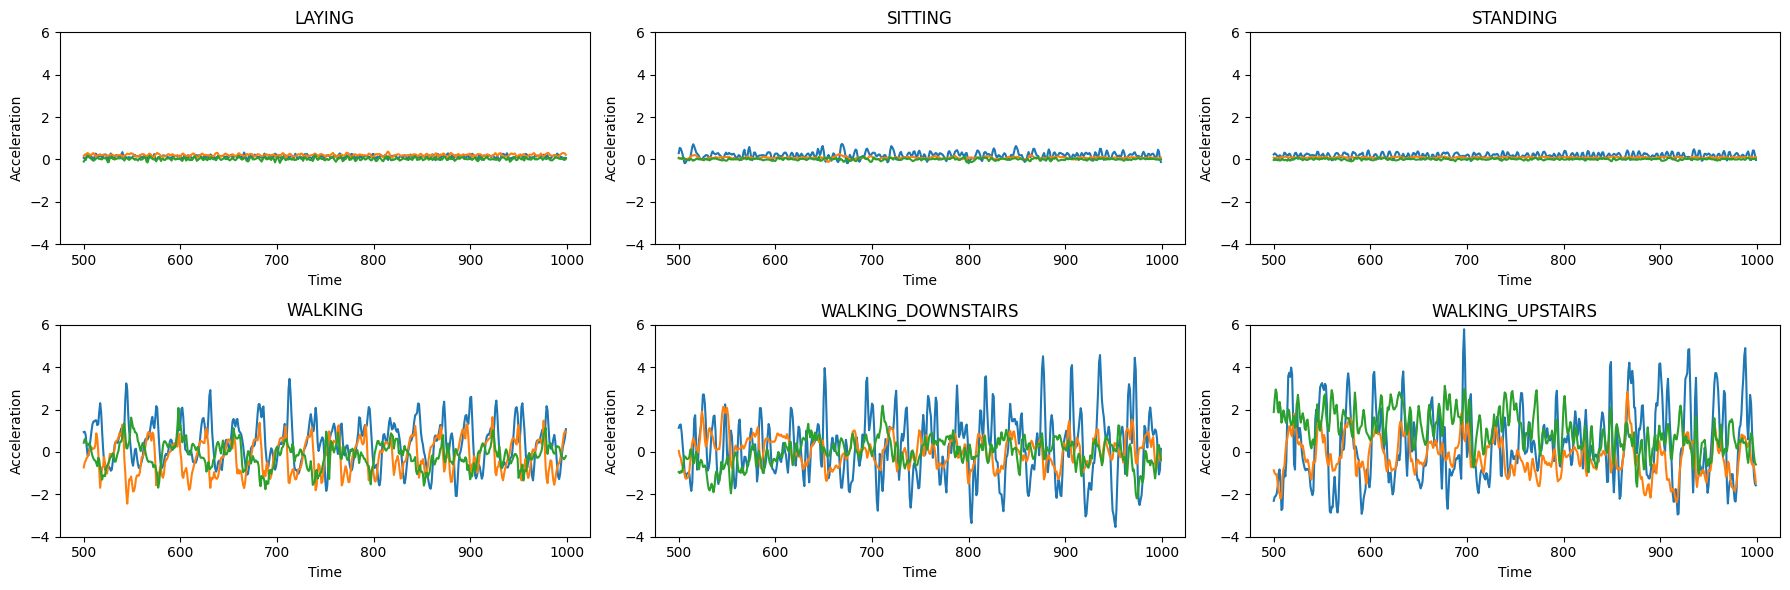

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths for each activity CSV
file_paths = [
    '/content/Collected_Data/Person_1/LAYING.csv',
    '/content/Collected_Data/Person_1/SITTING.csv',
    '/content/Collected_Data/Person_1/STANDING.csv',
    '/content/Collected_Data/Person_1/WALKING.csv',
    '/content/Collected_Data/Person_1/WALKING_DOWNSTAIRS.csv',
    '/content/Collected_Data/Person_1/WALKING_UPSTAIRS.csv'
]

# Initialize a list to store data for each activity
data_samples_1 = []

# Load one sample from each activity
for file_path in file_paths:
    data = pd.read_csv(file_path)
    data = data.iloc[500:1000,2:5]
    data_samples_1.append((file_path.split("/")[-1].split(".")[0], data))

# Plot the waveforms
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 6))
axes1 =axes1.flatten()
for i, (activity, data) in enumerate(data_samples_1):
    axes1[i].plot(data.iloc[:, 0:3])  # Plotting the first three columns (e.g., x, y, z accelerations)
    axes1[i].set_title(activity)
    axes1[i].set_xlabel('Time')
    axes1[i].set_ylabel('Acceleration')

    axes1[i].set_ylim(-4, 6)

plt.tight_layout()
plt.show()

In [ ]:
for file_path in file_paths:
    # Reading the CSV file
    df = pd.read_csv(file_path)
    print(df.shape)

(1622, 5)
(1790, 5)
(1599, 5)
(1560, 5)
(1784, 5)
(1537, 5)


In [ ]:
def collect_file_paths(base_dir):
    file_paths = []

    # Traverse the folder structure
    for root, dirs, files in os.walk(base_dir):
        for file_path in files:
            if file_path.endswith(".csv"):  # Ensure only CSV files are collected
                file_paths.append(os.path.join(root, file_path))

    return file_paths

In [ ]:
base_dir = '/content/Collected_Data'
file_paths = collect_file_paths(base_dir)

activity_map = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

reverse_map ={
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 2,
    'WALKING_DOWNSTAIRS' : 3,
    'SITTING' : 4,
    'STANDING' : 5,
    'LAYING' : 6
}

4.1 Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use
 -  Raw data from accelerometer,
 - TSFEL featurised data,
 - Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform? [1 marks]

In [ ]:
def load_and_preprocess_activity_data(file_paths):
    data = []
    labels = []

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df = df[500:1000]
        df = df[['x','y','z']]

        # scaler = StandardScaler()
        # df['total_acc'] = scaler.fit_transform(df['total_acc'].values)

        data.append(df)
        label= np.full((500,),reverse_map[file_path.split("/")[-1].split(".")[0]])
        labels.append(label)

    # Convert labels and data to numpy array
    labels = np.hstack(labels)
    data = pd.concat(data)

    return data, labels

In [ ]:
own_acitivty_data, own_activity_label = load_and_preprocess_activity_data(file_paths)

scaler = StandardScaler()
sacled_own_acitivty_data = scaler.fit_transform(own_acitivty_data)

print(f"Own data shape: {sacled_own_acitivty_data.shape}")
print(f"Own label shape: {own_activity_label.shape}")

print(sacled_own_acitivty_data)
print(own_activity_label)

Own data shape: (3000, 3)
Own label shape: (3000,)
[[-1.6896039   0.08162957  0.86038373]
 [-1.77420547 -0.30035742  0.99252324]
 [-1.63884298 -0.49310318  1.01816229]
 ...
 [-0.76975419  1.51320466  0.17700522]
 [-0.680538    1.70770263  0.39789527]
 [-0.53748446  1.62009101  0.7992445 ]]
[3 3 3 ... 1 1 1]


In [ ]:
reshaped_label = own_activity_label.reshape(-1,1)

append_data_label = np.hstack((sacled_own_acitivty_data,reshaped_label))
np.random.shuffle(append_data_label)

small_subset_data = append_data_label[600:610,0:3]
small_subset_label = append_data_label[600:610,3:]
small_subset_label = small_subset_label.reshape(-1)

In [ ]:
model_path = "/content/raw_accelerometer_decision_tree_model.pkl"
with open(model_path, 'rb') as model_file:
    clf_raw_acc_loaded = pickle.load(model_file)
    input_data = np.array(own_acitivty_data)
    own_scaler = StandardScaler()
    own_scaler.fit_transform(raw_data_train)

    input_data = own_scaler.transform(input_data)

    y_pred = clf_raw_acc_loaded.predict(input_data)

    accuracy = accuracy_score(own_activity_label, y_pred)
    precision = precision_score(own_activity_label, y_pred, average='weighted')
    recall = recall_score(own_activity_label, y_pred, average='weighted')
    cm = confusion_matrix(own_activity_label, y_pred)

    print(f"Raw Data - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    print(f"Confusion Matrix:\n{cm_raw}\n")

Raw Data - Accuracy: 0.21066666666666667, Precision: 0.17958034172735077, Recall: 0.21066666666666667
Confusion Matrix:
[[1750 1278 1324   23  125    0]
 [1403 1884 1141    9   63    0]
 [1387 1146 1890   18   59    0]
 [ 505  405  124 3191  275    0]
 [1042  705  251  118 2384    0]
 [   0    0    0    0    0 4500]]



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Important to be noted)

In [ ]:
#labels_test_1 = np.array(labels_test_1) #To plot scatter plot we need np.array not list

4.2 Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform? [1 marks]

In [ ]:
#file_path.split("/")[-1].split(".")[0]

combined_data = []
combined_label = []
for file_path in file_paths:
  df = pd.read_csv(file_path)
  df = df[['x','y','z']]
  combined_data.append(df)
  activity = file_path.split("/")[-1].split(".")[0]
  label = np.full(df.shape[0],reverse_map[activity])
  combined_label.append(label)

combined_data = pd.concat(combined_data, ignore_index=True)
combined_label = np.hstack(combined_label)

print("Combined label: ",combined_label.shape)
print("Combined data: ",combined_data.shape)

Combined label:  (9892,)
Combined data:  (9892, 3)


In [ ]:
np.unique(own_activity_label)

array([1, 2, 3, 4, 5, 6])

In [ ]:
from sklearn.model_selection import train_test_split
X_train_data = np.array(combined_data)
y_train_data = np.array(combined_label)

# Splitting the data into training and testing sets (optional but recommended for evaluation)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

accuracy_1 = accuracy_score(y_test, y_pred)
precision_1 = precision_score(y_test, y_pred, average='weighted')
recall_1 = recall_score(y_test, y_pred, average='weighted')
conf_matrix_1 = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy_1}")
print(f"Precision: {precision_1}")
print(f"Recall: {recall_1}")
print(f"Confusion Matrix:\n{conf_matrix_1}")

Accuracy: 0.8625721072276892
Precision: 0.8630225112362335
Recall: 0.8625721072276892
Confusion Matrix:
[[457  18  21   0   0   0]
 [ 63 364  44   0   0   0]
 [ 20  50 350   0   0   0]
 [  0   0   0 376 115   0]
 [  0   0   0  74 458   0]
 [  0   0   0   0   0 537]]


4.3 Use the Few-Shot prompting method using UCI-HAR dataset to predict the activities that you performed. Ensure that both your examples and test query undergo similar preprocessing. How did the model perform? [1 marks]

In [ ]:
print(small_subset_data.shape)
print(small_subset_label.shape)

(10, 3)
(10,)


In [ ]:
small_subset_data

array([[-0.4651886 ,  1.25562634,  0.09712981],
       [ 0.32852785, -0.7436726 , -0.11389904],
       [ 3.56338378,  0.33920796, -0.55272072],
       [-0.19754003,  0.19727701, -0.28252491],
       [-0.17600509, -0.78222177, -1.27948829],
       [-0.26214485,  0.12193095, -0.23716356],
       [-0.18061971,  0.23757839,  0.23518608],
       [-0.24522454,  0.12017871, -0.33577518],
       [-0.20061645,  0.34972136, -0.08628779],
       [-0.8282062 , -2.00878546,  0.04289341]])

In [ ]:
small_subset_label

array([3., 1., 2., 4., 1., 4., 4., 5., 6., 1.])

In [ ]:
# Get unique values in y_train_data
unique_values = np.unique(own_activity_label)

# Find the indices of each unique value
unique_indices = {val: np.where(own_activity_label == val)[0] for val in unique_values}

indices = []

for i in range(len(unique_values)):
    indices.append(unique_indices[i+1][0])

print(indices)

# Print the indices of each unique value
# for val, indices in unique_indices.items():
#     print(f"Value: {val}, Indices: {indices}")

[2500, 500, 0, 2000, 1500, 1000]


In [ ]:
raw_data_train_numpy = raw_data_train.to_numpy()

In [ ]:
raw_labels_train.shape

(63000, 1)

In [ ]:
activity_map.get(raw_labels_train[0][0])

'SITTING'

In [ ]:
few_shot_predictions_own_data = []

# Iterate through each sample in the test subset
for i in range(len(small_subset_data)):
    # Get the features for the current sample
    sample_features = ', '.join(map(str, small_subset_data[i]))

    few_shot_prompt = f"""
    * You are an activity recognition model.
    * Your task is to analyze the given accelerometer data features and classify the human activity and give only the activity label in the output.

    Examples:
    1. Features: {', '.join(map(str, raw_data_train_numpy[0]))} | Activity: {activity_map.get(raw_labels_train[0][0], 'Unknown')}
    2. Features: {', '.join(map(str, raw_data_train_numpy[10500]))} | Activity: {activity_map.get(raw_labels_train[10500][0], 'Unknown')}
    3. Features: {', '.join(map(str, raw_data_train_numpy[21002]))} | Activity: {activity_map.get(raw_labels_train[21002][0], 'Unknown')}
    4. Features: {', '.join(map(str, raw_data_train_numpy[31505]))} | Activity: {activity_map.get(raw_labels_train[31505][0], 'Unknown')}
    5. Features: {', '.join(map(str, raw_data_train_numpy[42010]))} | Activity: {activity_map.get(raw_labels_train[42010][0], 'Unknown')}
    6. Features: {', '.join(map(str, raw_data_train_numpy[52550]))} | Activity: {activity_map.get(raw_labels_train[52550][0], 'Unknown')}

    Predict the activity for: {sample_features}.
    """

    # Invoke Few-Shot Learning model
    response_fsl = llm.invoke(few_shot_prompt)
    fsl_prediction = response_fsl.content.strip()

    few_shot_predictions_own_data.append(fsl_prediction)
    print("Few-Shot Learning Prediction:", fsl_prediction)

    # Get the actual activity
    actual_activity = activity_map.get(small_subset_label[i])
    print("Actual activity: ", actual_activity)

# Ensure correct comparison for accuracy
correct_few_shot = sum(activity_map.get(small_subset_label[i]) == few_shot_predictions_own_data[i] for i in range(len(small_subset_data)))
few_shot_accuracy = correct_few_shot / len(small_subset_data)
print(f"Few-Shot Learning Accuracy: {few_shot_accuracy}")


Few-Shot Learning Prediction: LAYING
Actual activity:  WALKING_DOWNSTAIRS
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING_UPSTAIRS
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  SITTING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  SITTING
Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  SITTING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  STANDING
Few-Shot Learning Prediction: WALKING
Actual activity:  LAYING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Accuracy: 0.0


4.4 Use the Few-Shot prompting method using the data you collected to predict the activities that you performed. Adopt proper processing methods as needed. How did the model perform? [1 marks]

In [ ]:
own_data_numpy = own_acitivty_data.to_numpy()

In [ ]:
print( own_data_numpy[indices[0]])
print(own_activity_label[indices[0]])

[ 0.43599999 -0.72799999  0.93900001]
1


In [ ]:
few_shot_predictions_own_data = []

# Iterate through each sample in the test subset
for i in range(len(small_subset_label)):
    # Get the features for the current sample
    sample_features = ', '.join(map(str, small_subset_data[i]))

    few_shot_prompt = f"""
    * You are an activity recognition model.
    * Your task is to analyze the given accelerometer data features and classify the human activity and give only the activity label in the output.

    Examples:
    1. Features: {', '.join(map(str, own_data_numpy[indices[0]]))} | Activity: {activity_map.get(own_activity_label[indices[0]], 'Unknown')}
    2. Features: {', '.join(map(str, own_data_numpy[indices[1]]))} | Activity: {activity_map.get(own_activity_label[indices[1]], 'Unknown')}
    3. Features: {', '.join(map(str, own_data_numpy[indices[2]]))} | Activity: {activity_map.get(own_activity_label[indices[2]], 'Unknown')}
    4. Features: {', '.join(map(str, own_data_numpy[indices[3]]))} | Activity: {activity_map.get(own_activity_label[indices[3]], 'Unknown')}
    5. Features: {', '.join(map(str, own_data_numpy[indices[4]]))} | Activity: {activity_map.get(own_activity_label[indices[4]], 'Unknown')}
    6. Features: {', '.join(map(str, own_data_numpy[indices[5]]))} | Activity: {activity_map.get(own_activity_label[indices[5]], 'Unknown')}

    Predict the activity for: {sample_features}.
    """

    # Invoke Few-Shot Learning model
    response_fsl = llm.invoke(few_shot_prompt)
    fsl_prediction = response_fsl.content.strip()

    few_shot_predictions_own_data.append(fsl_prediction)
    print("Few-Shot Learning Prediction:", fsl_prediction)

    # Get the actual activity
    actual_activity = activity_map.get(small_subset_label[i])
    print("Actual activity: ", actual_activity)

# Ensure correct comparison for accuracy
correct_few_shot = sum(activity_map.get(small_subset_label[i]) == few_shot_predictions_own_data[i] for i in range(len(small_subset_data)))
few_shot_accuracy = correct_few_shot / len(small_subset_label)
print(f"Few-Shot Learning Accuracy: {few_shot_accuracy}")

Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING_DOWNSTAIRS
Few-Shot Learning Prediction: WALKING
Actual activity:  WALKING
Few-Shot Learning Prediction: WALKING_UPSTAIRS
Actual activity:  WALKING_UPSTAIRS
Few-Shot Learning Prediction: STANDING
Actual activity:  SITTING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Prediction: STANDING
Actual activity:  SITTING
Few-Shot Learning Prediction: STANDING
Actual activity:  SITTING
Few-Shot Learning Prediction: STANDING
Actual activity:  STANDING
Few-Shot Learning Prediction: STANDING
Actual activity:  LAYING
Few-Shot Learning Prediction: WALKING_DOWNSTAIRS
Actual activity:  WALKING
Few-Shot Learning Accuracy: 0.3


When used TSFEL format

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 0_FFT mean coefficient_251
- 0_FFT mean coefficient_252
- 0_FFT mean coefficient_253
- 0_FFT mean coefficient_254
- 0_FFT mean coefficient_255

# Decision Tree Implementation

1. Complete the decision tree implementation in tree/base.py. The code should be written in Python and not use existing libraries other than the ones shared in class or already imported in the code. Your decision tree should work for four cases:
   1. discrete features, discrete output;
   2. discrete features, real output;
   3. real features, discrete output;
   4. real features, real output.

<u>Your model should accept real inputs only (for discrete inputs, you may convert the attributes into one-hot encoded vectors)</u>. Your decision tree should be able to use InformationGain using Entropy or GiniIndex as the criteria for splitting for discrete output. Your decision tree should be able to use InformationGain using MSE as the criteria for splitting for real output. Your code should also be able to plot/display the decision tree.  **[2.5 marks]**

You should be editing the following files.
  
  - `metrics.py`: Complete the performance metrics functions in this file.

  - `usage.py`: Run this file to check your solutions.

  - tree (Directory): Module for decision tree.
      - `base.py` : Complete Decision Tree Class.
      - `utils.py`: Complete all utility functions.
      - `__init__.py`: **Do not edit this**

> You should run _usage.py_ to check your solutions.

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (101 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree /content/UCI_HAR_Decision_Tree

/content/UCI_HAR_Decision_Tree
├── auto-efficiency.py
├── classification-exp-one.py
├── classification-exp.py
├── experiments.py
├── HAR
│   └── ZeroShot_FewShot.ipynb
├── metrics.py
├── README.md
├── tree
│   ├── base.py
│   ├── __init__.py
│   └── utils.py
└── usage.py

2 directories, 11 files


In [ ]:
!python /content/UCI_HAR_Decision_Tree/usage.py


Test case 1--> Real Input and Real Output

--------------------------------------------------
Criteria : mse

?(1 <= -1.236950710878082)
  Y:   Class: 2.720169166589619
  N:   ?(4 <= 0.25988279424842353)
    Y:     ?(0 <= 1.465648768921554)
      Y:       ?(4 <= -1.763040155362734)
        Y:         ?(1 <= 0.08704706823817122)
          Y:           ?(0 <= -0.7198442083947086)
            Y:             Class: 0.6565536086338297
            N:             Class: 0.4127809269364983
          N:           Class: 0.9633761292443218
        N:         ?(2 <= 1.0035328978920242)
          Y:           ?(3 <= -0.9080240755212109)
            Y:             ?(3 <= -1.913280244657798)
              Y:               Class: -0.6800247215784908
              N:               ?(0 <= -1.2208436499710222)
                Y:                 Class: 0.4738329209117875
                N:                 ?(0 <= -0.5622875292409727)
                  Y:                   Class: 0.23225369716100355
     

2. Generate your dataset using the following lines of code



  ```
  from sklearn.datasets import make_classification
  X, y = make_classification(
  n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

  # For plotting
  import matplotlib.pyplot as plt
  plt.scatter(X[:, 0], X[:, 1], c=y)
  ```

a) Show the usage of your decision tree on the above dataset. The first 70% of the data should be used for training purposes and the remaining 30% for test purposes. Show the accuracy, per-class precision and recall of the decision tree you implemented on the test dataset. [0.5 mark]

b) Use 5 fold cross-validation on the dataset. Using nested cross-validation find the optimum depth of the tree. [1 mark]

   > You should be editing `classification-exp.py` for the code containing the above experiments.

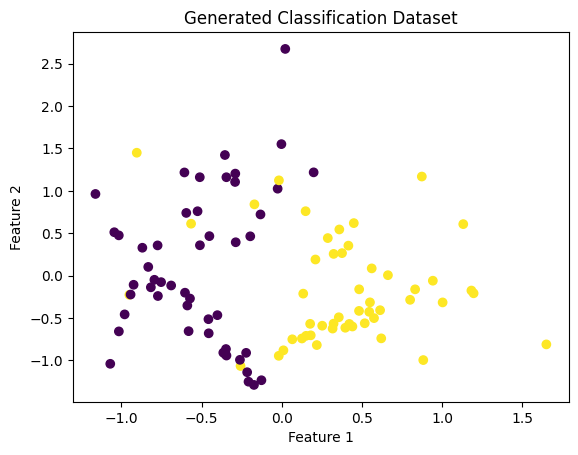

In [ ]:

from sklearn.datasets import make_classification
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Classification Dataset')
plt.show()

In [ ]:
!python /content/UCI_HAR_Decision_Tree/classification-exp.py

Figure(640x480)
Accuracy: 0.50
Precision:
  Class 0: 0.50
  Class 1: 0.00
Recall:
  Class 0: 1.00
  Class 1: 0.00
Outer Fold 1 - Training Shape: (80, 2)
Best depth for Outer Fold 1: 1 with accuracy: 0.3750
Outer Fold 2 - Training Shape: (80, 2)
Best depth for Outer Fold 2: 1 with accuracy: 0.5625
Outer Fold 3 - Training Shape: (80, 2)
Best depth for Outer Fold 3: 1 with accuracy: 0.4125
Outer Fold 4 - Training Shape: (80, 2)
Best depth for Outer Fold 4: 1 with accuracy: 0.4250
Outer Fold 5 - Training Shape: (80, 2)
Best depth for Outer Fold 5: 1 with accuracy: 0.4250
Outer Fold 1 - Accuracy: 0.5000
  Class 0 - Precision: 0.5000
  Class 1 - Precision: 0.0000
  Class 0 - Recall: 1.0000
  Class 1 - Recall: 0.0000
Outer Fold 2 - Accuracy: 0.2500
  Class 0 - Precision: 0.0000
  Class 1 - Precision: 0.2500
  Class 0 - Recall: 0.0000
  Class 1 - Recall: 1.0000
Outer Fold 3 - Accuracy: 0.4500
  Class 0 - Precision: 0.4500
  Class 1 - Precision: 0.0000
  Class 0 - Recall: 1.0000
  Class 1 - Rec

3. a) Show the usage of your decision tree for the [automotive efficiency](https://archive.ics.uci.edu/ml/datasets/auto+mpg) problem. **[0.5 marks]**
  
  b) Compare the performance of your model with the decision tree module from scikit learn. [0.5 marks]
    
   > You should be editing `auto-efficiency.py` for the code containing the above experiments.

In [ ]:
!python /content/UCI_HAR_Decision_Tree/auto-efficiency.py

Custom Decision Tree Performance:
Accuracy: 0.4491525423728814
Precision: 0.4491525423728814
Recall: 1.0
F1 Score: 0.6198830409356725

Scikit-learn Decision Tree Performance:
Accuracy: 0.8898305084745762
Precision: 0.8125
Recall: 0.9811320754716981
F1 Score: 0.8888888888888888
Figure(640x480)


In [ ]:
!python /content/UCI_HAR_Decision_Tree/classification-exp-one.py

Optimal tree depth: 1
Accuracy with optimal depth: 0.50
Precision:
  Class 0: 0.50
  Class 1: 0.00
Recall:
  Class 0: 1.00
  Class 1: 0.00


4. Create some fake data to do some experiments on the runtime complexity of your decision tree algorithm. Create a dataset with N samples and M binary features. Vary M and N to plot the time taken for:

  1) learning the tree,

  2) predicting for test data. How do these results compare with theoretical time complexity for decision tree creation and prediction. You should do the comparison for all the four cases of decision trees. [1 marks]

  > You should be editing `experiments.py` for the code containing the above experiments.

In [ ]:
!python /content/UCI_HAR_Decision_Tree/experiments.py

Figure(640x480)


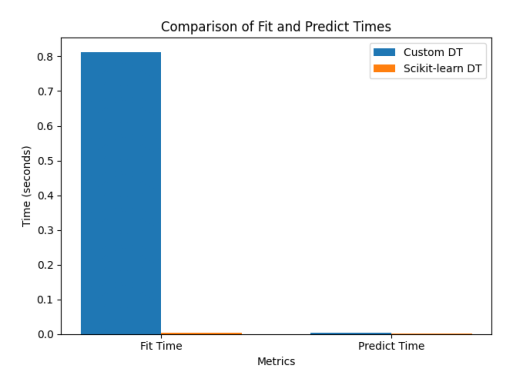

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image file
image_path = '/content/comparison_plot.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


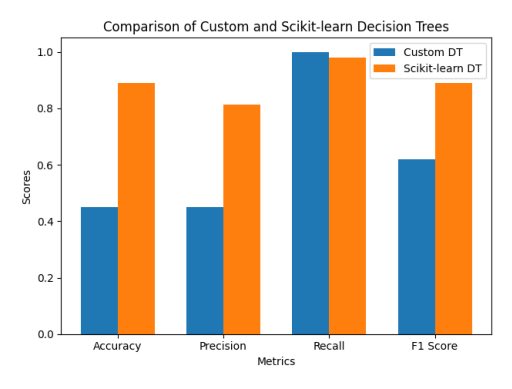

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the image file
image_path = '/content/Comparison of Decision Trees.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


### Before One-Hot-Encoding on Discrete Inputs (Optional)


```
 Test case 1--> Real Input and Real Output
?(0 <= 0.11092258970986608)
  Y:   ?(0 <= -0.5622875292409727)
    Y:     ?(0 <= -1.4153707420504142)
      Y:       ?(0 <= -1.5506634310661327)
        Y:         ?(0 <= -1.9187712152990415)
          Y:           Class: -0.0771017094141042
          N:           Class: 0.01300189187790702
        N:         ?(0 <= -1.4635149481321186)
          Y:           Class: -0.7537361643574896
          N:           Class: -0.8895144296255233
      N:       ?(0 <= -0.7198442083947086)
        Y:         ?(0 <= -1.2208436499710222)
          Y:           Class: 0.4738329209117875
          N:           Class: 0.6565536086338297
        N:         ?(0 <= -0.6017066122293969)
          Y:           Class: 1.8657745111447566
          N:           Class: 0.23225369716100355
    N:     ?(0 <= -0.23413695694918055)
      Y:       ?(0 <= -0.47917423784528995)
        Y:         ?(0 <= -0.5017570435845365)
          Y:           Class: 1.8967929826539474
          N:           Class: 1.158595579007404
        N:         ?(0 <= -0.46341769281246226)
          Y:           Class: -0.6800247215784908
          N:           Class: 0.3464482094969757
      N:       ?(0 <= -0.21967188783751193)
        Y:         Class: 0.82206015999449
        N:         ?(0 <= 0.09707754934804039)
          Y:           Class: -0.2453881160028705
          N:           Class: -0.7143514180263678
  N:   ?(0 <= 0.7384665799954104)
    Y:     ?(0 <= 0.324083969394795)
      Y:       ?(0 <= 0.30154734233361247)
        Y:         ?(0 <= 0.22745993460412942)
          Y:           Class: -0.2646568332379561
          N:           Class: 0.3411519748166439
        N:         Class: -0.9746816702273214
      N:       ?(0 <= 0.4040508568145384)
        Y:         ?(0 <= 0.36139560550841393)
          Y:           Class: 0.9633761292443218
          N:           Class: -0.8158102849654383
        N:         ?(0 <= 0.4967141530112327)
          Y:           Class: 0.25049285034587654
          N:           Class: -1.1913034972026486
    N:     ?(0 <= 0.9312801191161986)
      Y:       ?(0 <= 0.7910319470430469)
        Y:         ?(0 <= 0.7818228717773104)
          Y:           Class: 2.720169166589619
          N:           Class: 0.27669079933001905
        N:         ?(0 <= 0.8219025043752238)
          Y:           Class: 0.4127809269364983
          N:           Class: 0.787084603742452
      N:       ?(0 <= 1.465648768921554)
        Y:         ?(0 <= 1.356240028570823)
          Y:           Class: -0.8206823183517105
          N:           Class: 0.29307247329868125
        N:         ?(0 <= 1.5499344050175394)
          Y:           Class: 1.4535340771573169
          N:           Class: 0.8271832490360238
Criteria : information_gain
RMSE:  0.0
MAE:  0.0
Class: 0.25049285034587654
Criteria : gini_index
RMSE:  0.9318723148644747
MAE:  0.7241872798302714

Test case 2--->Real Input and Discrete Output
?(0 <= 0.46210347426327075)
  Y:   ?(1 <= 0.9178619470547761)
    Y:     ?(2 <= -0.5893647569442115)
      Y:       ?(0 <= -0.926930471578083)
        Y:         Class: 0
        N:         ?(0 <= -0.3345012358409484)
          Y:           Class: 1
          N:           Class: 2
      N:       ?(2 <= -0.31026675659345604)
        Y:         Class: 4
        N:         ?(4 <= 2.1439440893253257)
          Y:           Class: 1
          N:           Class: 4
    N:     ?(2 <= -0.7076694656187807)
      Y:       ?(0 <= -1.2477831819648495)
        Y:         Class: 4
        N:         Class: 3
      N:       Class: 4
  N:   ?(1 <= -2.025142586657607)
    Y:     Class: 3
    N:     ?(4 <= -0.9815086510479509)
      Y:       Class: 4
      N:       ?(0 <= 0.7589692204932674)
        Y:         ?(0 <= 0.570890510693167)
          Y:           Class: 2
          N:           Class: 4
        N:         Class: 2
Criteria : information_gain
Accuracy:  0.9
CLASS:  4
Precision:  1.0
Recall:  1.0
CLASS:  1
Precision:  0.8181818181818182
Recall:  0.9
CLASS:  2
Precision:  0.8333333333333334
Recall:  1.0
CLASS:  3
Precision:  1.0
Recall:  1.0
CLASS:  0
Precision:  1.0
Recall:  0.3333333333333333
Class: 1
Criteria : gini_index
Accuracy:  0.3333333333333333
CLASS:  4
Precision:  0.0
Recall:  0.0
CLASS:  1
Precision:  0.3333333333333333
Recall:  1.0
CLASS:  2
Precision:  0.0
Recall:  0.0
CLASS:  3
Precision:  0.0
Recall:  0.0
CLASS:  0
Precision:  0.0
Recall:  0.0

Test case 3--> Discrete Input and Discrete Output
?(1 <= 0)
  Y:   ?(4 <= 1)
    Y:     Class: 0
    N:     ?(0 <= 2)
      Y:       Class: 0
      N:       ?(0 <= 3)
        Y:         ?(3 <= 1)
          Y:           Class: 0
          N:           Class: 4
        N:         Class: 4
  N:   ?(1 <= 4)
    Y:     ?(2 <= 3)
      Y:       Class: 1
      N:       ?(0 <= 4)
        Y:         Class: 1
        N:         Class: 3
    N:     ?(4 <= 3)
      Y:       ?(0 <= 1)
        Y:         Class: 3
        N:         Class: 1
      N:       ?(3 <= 2)
        Y:         ?(0 <= 4)
          Y:           Class: 0
          N:           Class: 3
        N:         ?(3 <= 0)
          Y:           Class: 0
          N:           Class: 2
Criteria : information_gain
Accuracy:  0.43333333333333335
CLASS:  0
Precision:  0.5
Recall:  0.42857142857142855
CLASS:  4
Precision:  1.0
Recall:  0.5
CLASS:  1
Precision:  0.36363636363636365
Recall:  0.8888888888888888
CLASS:  2
Precision:  0.0
Recall:  0.0
CLASS:  3
Precision:  0.0
Recall:  0.0
?(2 <= 2)
  Y:   Class: 0
  N:   ?(0 <= 3)
    Y:     Class: 0
    N:     ?(4 <= 1)
      Y:       Class: 0
      N:       ?(0 <= 4)
        Y:         Class: 1
        N:         ?(2 <= 4)
          Y:           Class: 0
          N:           Class: 1
Criteria : gini_index
Accuracy:  0.23333333333333334
CLASS:  0
Precision:  0.2413793103448276
Recall:  1.0
CLASS:  4
Precision:  0.0
Recall:  0.0
CLASS:  1
Precision:  0.0
Recall:  0.0
CLASS:  2
Precision:  0.0
Recall:  0.0
CLASS:  3
Precision:  0.0
Recall:  0.0

Test case 4-->Discrete Input and Real Output
?(0 <= 2)
  Y:   ?(4 <= 3)
    Y:     ?(1 <= 0)
      Y:       ?(2 <= 4)
        Y:         Class: -0.6039851867158206
        N:         Class: -0.4118769661224674
      N:       ?(1 <= 1)
        Y:         Class: 0.57707212718054
        N:         ?(3 <= 0)
          Y:           Class: 0.2544208433012131
          N:           Class: 0.2897748568964129
    N:     ?(1 <= 4)
      Y:       ?(2 <= 2)
        Y:         Class: -0.2030453860429927
        N:         ?(2 <= 1)
          Y:           Class: 0.3376026620752022
          N:           Class: 2.075400798645439
      N:       ?(1 <= 1)
        Y:         Class: -2.4716445001272893
        N:         Class: -0.7968952554704768
  N:   ?(0 <= 4)
    Y:     ?(1 <= 1)
      Y:       ?(3 <= 3)
        Y:         ?(2 <= 0)
          Y:           Class: -0.48760622407249354
          N:           Class: -1.008086310917404
        N:         ?(2 <= 4)
          Y:           Class: 1.4415686206579004
          N:           Class: -0.32602353216784113
      N:       ?(2 <= 2)
        Y:         ?(3 <= 0)
          Y:           Class: -0.5768918695231487
          N:           Class: -1.129706854657618
        N:         ?(1 <= 0)
          Y:           Class: 0.39445214237829684
          N:           Class: 0.8711247034316923
    N:     ?(0 <= 1)
      Y:       ?(1 <= 3)
        Y:         ?(2 <= 3)
          Y:           Class: 0.5298041779152828
          N:           Class: -0.4325581878196209
        N:         ?(1 <= 4)
          Y:           Class: 0.8356921120651418
          N:           Class: -0.42098448082026296
      N:       ?(0 <= 3)
        Y:         ?(1 <= 1)
          Y:           Class: 0.08658978747289992
          N:           Class: 1.0062928092144405
        N:         ?(1 <= 2)
          Y:           Class: 0.37114587337130883
          N:           Class: 1.1677820616598074
Criteria : information_gain
RMSE:  1.1823688764956892
MAE:  0.7814132523115405
?(0 <= 3)
  Y:   Class: 1.0062928092144405
  N:   ?(0 <= 4)
    Y:     Class: -0.5768918695231487
    N:     ?(1 <= 3)
      Y:       Class: 0.5298041779152828
      N:       ?(0 <= 1)
        Y:         Class: 0.8356921120651418
        N:         ?(0 <= 0)
          Y:           Class: 0.37114587337130883
          N:           Class: -2.4716445001272893
Criteria : gini_index
RMSE:  1.2940914762853464
MAE:  0.9987179357163412

```